In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1t2_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:38 - loss: 0.1777 - STD: 1.5148e-04 - MAE: 0.4085

 4/64 [>.............................] - ETA: 1s - loss: 0.0632 - STD: 3.8017e-04 - MAE: 0.1914  

 7/64 [==>...........................] - ETA: 1s - loss: 0.0511 - STD: 2.6828e-04 - MAE: 0.1735

10/64 [===>..........................] - ETA: 1s - loss: 0.0474 - STD: 1.9909e-04 - MAE: 0.1698

13/64 [=====>........................] - ETA: 1s - loss: 0.0437 - STD: 1.5990e-04 - MAE: 0.1622

16/64 [======>.......................] - ETA: 1s - loss: 0.0394 - STD: 1.3754e-04 - MAE: 0.1486

19/64 [=======>......................] - ETA: 1s - loss: 0.0352 - STD: 1.2293e-04 - MAE: 0.1363

22/64 [=========>....................] - ETA: 1s - loss: 0.0327 - STD: 1.1189e-04 - MAE: 0.1328

25/64 [==========>...................] - ETA: 0s - loss: 0.0309 - STD: 1.0249e-04 - MAE: 0.1308

28/64 [============>.................] - ETA: 0s - loss: 0.0290 - STD: 9.4260e-05 - MAE: 0.1262

30/64 [=============>................] - ETA: 0s - loss: 0.0280 - STD: 8.9507e-05 - MAE: 0.1221

33/64 [==============>...............] - ETA: 0s - loss: 0.0266 - STD: 8.3416e-05 - MAE: 0.1165

36/64 [===============>..............] - ETA: 0s - loss: 0.0256 - STD: 7.8422e-05 - MAE: 0.1118

39/64 [=================>............] - ETA: 0s - loss: 0.0247 - STD: 7.4367e-05 - MAE: 0.1079

41/64 [==================>...........] - ETA: 0s - loss: 0.0244 - STD: 7.2093e-05 - MAE: 0.1059

43/64 [===================>..........] - ETA: 0s - loss: 0.0238 - STD: 7.0159e-05 - MAE: 0.1045

45/64 [====================>.........] - ETA: 0s - loss: 0.0233 - STD: 6.8467e-05 - MAE: 0.1035

48/64 [=====================>........] - ETA: 0s - loss: 0.0227 - STD: 6.6312e-05 - MAE: 0.1022

51/64 [======================>.......] - ETA: 0s - loss: 0.0221 - STD: 6.4509e-05 - MAE: 0.1006

54/64 [========================>.....] - ETA: 0s - loss: 0.0215 - STD: 6.2981e-05 - MAE: 0.0988

56/64 [=========================>....] - ETA: 0s - loss: 0.0212 - STD: 6.2100e-05 - MAE: 0.0976

59/64 [==========================>...] - ETA: 0s - loss: 0.0208 - STD: 6.1015e-05 - MAE: 0.0959

62/64 [============================>.] - ETA: 0s - loss: 0.0204 - STD: 6.0196e-05 - MAE: 0.0945

64/64 [==============================] - 4s 46ms/step - loss: 0.0202 - STD: 5.9785e-05 - MAE: 0.0938 - val_loss: 0.0167 - val_STD: 3.6278e-05 - val_MAE: 0.0819


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0124 - STD: 4.9178e-05 - MAE: 0.0719

 3/64 [>.............................] - ETA: 1s - loss: 0.0125 - STD: 5.0388e-05 - MAE: 0.0728

 5/64 [=>............................] - ETA: 1s - loss: 0.0126 - STD: 5.1746e-05 - MAE: 0.0735

 7/64 [==>...........................] - ETA: 1s - loss: 0.0127 - STD: 5.2903e-05 - MAE: 0.0733

10/64 [===>..........................] - ETA: 1s - loss: 0.0127 - STD: 5.4813e-05 - MAE: 0.0726

12/64 [====>.........................] - ETA: 1s - loss: 0.0127 - STD: 5.5965e-05 - MAE: 0.0718

14/64 [=====>........................] - ETA: 1s - loss: 0.0127 - STD: 5.7269e-05 - MAE: 0.0713

16/64 [======>.......................] - ETA: 1s - loss: 0.0128 - STD: 5.8664e-05 - MAE: 0.0710

19/64 [=======>......................] - ETA: 1s - loss: 0.0128 - STD: 6.0929e-05 - MAE: 0.0708

22/64 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 6.3508e-05 - MAE: 0.0708

25/64 [==========>...................] - ETA: 0s - loss: 0.0128 - STD: 6.6226e-05 - MAE: 0.0710

28/64 [============>.................] - ETA: 0s - loss: 0.0128 - STD: 6.9081e-05 - MAE: 0.0711

31/64 [=============>................] - ETA: 0s - loss: 0.0127 - STD: 7.2080e-05 - MAE: 0.0709

33/64 [==============>...............] - ETA: 0s - loss: 0.0127 - STD: 7.4205e-05 - MAE: 0.0708

35/64 [===============>..............] - ETA: 0s - loss: 0.0128 - STD: 7.6438e-05 - MAE: 0.0708

38/64 [================>.............] - ETA: 0s - loss: 0.0128 - STD: 8.0091e-05 - MAE: 0.0708

41/64 [==================>...........] - ETA: 0s - loss: 0.0128 - STD: 8.4026e-05 - MAE: 0.0708

44/64 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 8.8304e-05 - MAE: 0.0707

47/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 9.2920e-05 - MAE: 0.0706

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 9.7942e-05 - MAE: 0.0706

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 1.0340e-04 - MAE: 0.0705

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 1.0946e-04 - MAE: 0.0704

59/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 1.1608e-04 - MAE: 0.0704

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 1.2333e-04 - MAE: 0.0704

64/64 [==============================] - 2s 28ms/step - loss: 0.0127 - STD: 1.2863e-04 - MAE: 0.0704 - val_loss: 0.0167 - val_STD: 2.2568e-04 - val_MAE: 0.0789


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0125 - STD: 3.0863e-04 - MAE: 0.0697

 3/64 [>.............................] - ETA: 1s - loss: 0.0125 - STD: 3.2057e-04 - MAE: 0.0695

 5/64 [=>............................] - ETA: 1s - loss: 0.0124 - STD: 3.3356e-04 - MAE: 0.0696

 8/64 [==>...........................] - ETA: 1s - loss: 0.0124 - STD: 3.5491e-04 - MAE: 0.0696

11/64 [====>.........................] - ETA: 1s - loss: 0.0125 - STD: 3.7848e-04 - MAE: 0.0695

14/64 [=====>........................] - ETA: 1s - loss: 0.0125 - STD: 4.0450e-04 - MAE: 0.0695

17/64 [======>.......................] - ETA: 1s - loss: 0.0126 - STD: 4.3403e-04 - MAE: 0.0696

19/64 [=======>......................] - ETA: 1s - loss: 0.0126 - STD: 4.5584e-04 - MAE: 0.0697

21/64 [========>.....................] - ETA: 1s - loss: 0.0126 - STD: 4.7938e-04 - MAE: 0.0698

24/64 [==========>...................] - ETA: 0s - loss: 0.0126 - STD: 5.1832e-04 - MAE: 0.0697

27/64 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 5.6332e-04 - MAE: 0.0697

30/64 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 6.1503e-04 - MAE: 0.0697

33/64 [==============>...............] - ETA: 0s - loss: 0.0126 - STD: 6.7472e-04 - MAE: 0.0697

36/64 [===============>..............] - ETA: 0s - loss: 0.0126 - STD: 7.4576e-04 - MAE: 0.0697

39/64 [=================>............] - ETA: 0s - loss: 0.0125 - STD: 8.2901e-04 - MAE: 0.0696

42/64 [==================>...........] - ETA: 0s - loss: 0.0125 - STD: 9.2671e-04 - MAE: 0.0696

45/64 [====================>.........] - ETA: 0s - loss: 0.0125 - STD: 0.0010 - MAE: 0.0695    

48/64 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0696

51/64 [======================>.......] - ETA: 0s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0695

54/64 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0694

57/64 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 0.0018 - MAE: 0.0692

60/64 [===========================>..] - ETA: 0s - loss: 0.0124 - STD: 0.0021 - MAE: 0.0691

63/64 [============================>.] - ETA: 0s - loss: 0.0123 - STD: 0.0024 - MAE: 0.0690

64/64 [==============================] - 2s 28ms/step - loss: 0.0123 - STD: 0.0026 - MAE: 0.0690 - val_loss: 0.0147 - val_STD: 0.0084 - val_MAE: 0.0739


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0113 - STD: 0.0119 - MAE: 0.0663

 3/64 [>.............................] - ETA: 1s - loss: 0.0111 - STD: 0.0127 - MAE: 0.0652

 5/64 [=>............................] - ETA: 1s - loss: 0.0110 - STD: 0.0138 - MAE: 0.0649

 8/64 [==>...........................] - ETA: 1s - loss: 0.0107 - STD: 0.0156 - MAE: 0.0638

10/64 [===>..........................] - ETA: 1s - loss: 0.0104 - STD: 0.0169 - MAE: 0.0628

12/64 [====>.........................] - ETA: 1s - loss: 0.0102 - STD: 0.0183 - MAE: 0.0621

15/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 0.0207 - MAE: 0.0611

18/64 [=======>......................] - ETA: 1s - loss: 0.0096 - STD: 0.0232 - MAE: 0.0600

21/64 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 0.0260 - MAE: 0.0588

24/64 [==========>...................] - ETA: 1s - loss: 0.0089 - STD: 0.0289 - MAE: 0.0576

27/64 [===========>..................] - ETA: 0s - loss: 0.0085 - STD: 0.0321 - MAE: 0.0564

30/64 [=============>................] - ETA: 0s - loss: 0.0082 - STD: 0.0354 - MAE: 0.0552

33/64 [==============>...............] - ETA: 0s - loss: 0.0079 - STD: 0.0385 - MAE: 0.0540

36/64 [===============>..............] - ETA: 0s - loss: 0.0076 - STD: 0.0418 - MAE: 0.0530

39/64 [=================>............] - ETA: 0s - loss: 0.0073 - STD: 0.0449 - MAE: 0.0521

42/64 [==================>...........] - ETA: 0s - loss: 0.0071 - STD: 0.0477 - MAE: 0.0511

44/64 [===================>..........] - ETA: 0s - loss: 0.0069 - STD: 0.0495 - MAE: 0.0505

47/64 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0521 - MAE: 0.0497

49/64 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0537 - MAE: 0.0492

52/64 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0560 - MAE: 0.0485

55/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0581 - MAE: 0.0478

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0472

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0466

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0635 - MAE: 0.0460

64/64 [==============================] - 2s 29ms/step - loss: 0.0057 - STD: 0.0635 - MAE: 0.0460 - val_loss: 0.0033 - val_STD: 0.0770 - val_MAE: 0.0380


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0345

 3/64 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.0994 - MAE: 0.0342

 6/64 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.0990 - MAE: 0.0345

 8/64 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.0986 - MAE: 0.0344

10/64 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.0988 - MAE: 0.0343

12/64 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0984 - MAE: 0.0341

15/64 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0983 - MAE: 0.0340

18/64 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0986 - MAE: 0.0338

20/64 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0982 - MAE: 0.0337

23/64 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0985 - MAE: 0.0336

26/64 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0988 - MAE: 0.0335

29/64 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.0985 - MAE: 0.0333

31/64 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.0988 - MAE: 0.0333

33/64 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0987 - MAE: 0.0333

35/64 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.0991 - MAE: 0.0332

38/64 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0991 - MAE: 0.0331

41/64 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0991 - MAE: 0.0330

44/64 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0992 - MAE: 0.0329

46/64 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0993 - MAE: 0.0328

48/64 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0995 - MAE: 0.0327

50/64 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0995 - MAE: 0.0326

53/64 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0995 - MAE: 0.0325

56/64 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0996 - MAE: 0.0324

59/64 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0997 - MAE: 0.0323

62/64 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0997 - MAE: 0.0322

64/64 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0998 - MAE: 0.0322

64/64 [==============================] - 2s 29ms/step - loss: 0.0023 - STD: 0.0998 - MAE: 0.0322 - val_loss: 0.0023 - val_STD: 0.0849 - val_MAE: 0.0322


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0302

 3/64 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0303

 5/64 [=>............................] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0302

 7/64 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0300

10/64 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0300

12/64 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0300

14/64 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0300

16/64 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0299

19/64 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0299

22/64 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0299

25/64 [==========>...................] - ETA: 0s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0299

27/64 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0299

29/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1017 - MAE: 0.0298

32/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0298

35/64 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0298

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0297

39/64 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0297

42/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0297

45/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0296

48/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0296

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0295

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0295

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0295

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0295

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0295

64/64 [==============================] - 2s 29ms/step - loss: 0.0019 - STD: 0.1024 - MAE: 0.0295 - val_loss: 0.0021 - val_STD: 0.0897 - val_MAE: 0.0304


Epoch 7/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0285

 3/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0285

 5/64 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0286

 7/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

10/64 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0284

13/64 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0285

16/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

19/64 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0286

22/64 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0287

24/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

29/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0290

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0290

35/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0290

38/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0291

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0290

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0290

44/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0290

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0289

48/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0289

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0289

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0288

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0288

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0288

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0287

64/64 [==============================] - 2s 28ms/step - loss: 0.0018 - STD: 0.1032 - MAE: 0.0287 - val_loss: 0.0021 - val_STD: 0.0931 - val_MAE: 0.0301


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1081 - MAE: 0.0285

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

10/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0279

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0279

16/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0279

19/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

22/64 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

27/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

30/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0277

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0277

35/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0277

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0277

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0277

44/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0277

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0275

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0275

64/64 [==============================] - 2s 28ms/step - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275 - val_loss: 0.0020 - val_STD: 0.0938 - val_MAE: 0.0286


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0268

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0269

 5/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0268

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0269

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0269

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0269

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0269

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0268

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0268

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0268

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0269

64/64 [==============================] - 2s 28ms/step - loss: 0.0016 - STD: 0.1046 - MAE: 0.0269 - val_loss: 0.0018 - val_STD: 0.0934 - val_MAE: 0.0273


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0267

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0268

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0267

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0267

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0267

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0268

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

64/64 [==============================] - 2s 28ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269 - val_loss: 0.0019 - val_STD: 0.0937 - val_MAE: 0.0282


Epoch 11/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0263

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0264

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

64/64 [==============================] - 2s 28ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0957 - val_MAE: 0.0275


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0256

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

64/64 [==============================] - 2s 28ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262 - val_loss: 0.0016 - val_STD: 0.0934 - val_MAE: 0.0263


Epoch 13/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0256

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0258

 5/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0258

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0259

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0259

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0259

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

64/64 [==============================] - 2s 28ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0957 - val_MAE: 0.0271


Epoch 14/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0255

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0262

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

14/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

64/64 [==============================] - 2s 28ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258 - val_loss: 0.0019 - val_STD: 0.0975 - val_MAE: 0.0285


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0262

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0258

 5/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

 8/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0256

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0260

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0262

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

64/64 [==============================] - 2s 28ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261 - val_loss: 0.0021 - val_STD: 0.0977 - val_MAE: 0.0305


Epoch 16/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0263

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0262

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0260

14/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0260

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

64/64 [==============================] - 2s 28ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257 - val_loss: 0.0018 - val_STD: 0.0952 - val_MAE: 0.0279


Epoch 17/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0262

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0260

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0259

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

64/64 [==============================] - 2s 28ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257 - val_loss: 0.0021 - val_STD: 0.0982 - val_MAE: 0.0298


Epoch 18/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0260

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

 6/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

12/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0252

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

64/64 [==============================] - 2s 28ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252 - val_loss: 0.0018 - val_STD: 0.0972 - val_MAE: 0.0275


Epoch 19/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0253

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

 6/64 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0249

 8/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0249

12/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0250

14/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0250

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0250

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0250

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0251

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

64/64 [==============================] - 2s 28ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253 - val_loss: 0.0022 - val_STD: 0.0981 - val_MAE: 0.0323


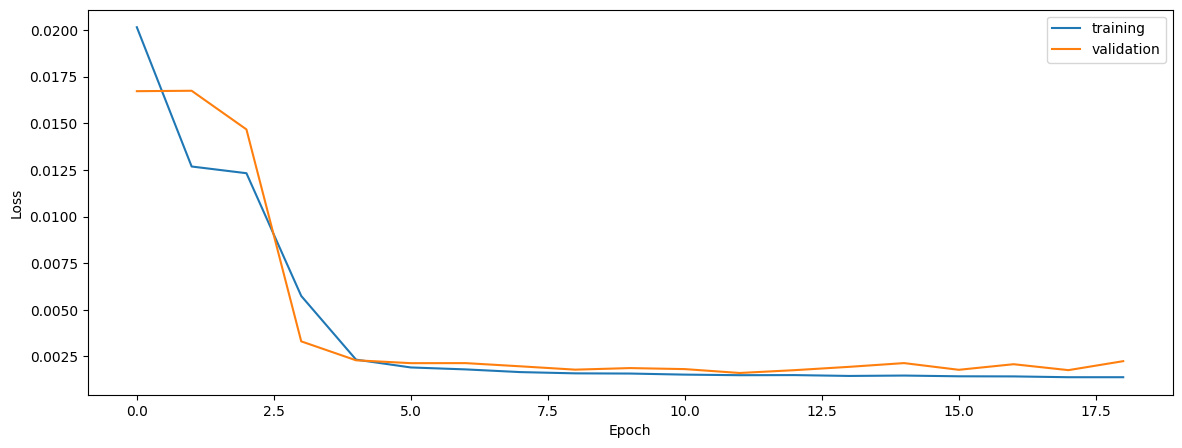

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9410713667643918
0.9519044596773955
0.9381444949680036


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9410713667643918
0.9519044596773955
0.9381444949680036


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9472082700812355
0.955886866760082
0.9503753299858397


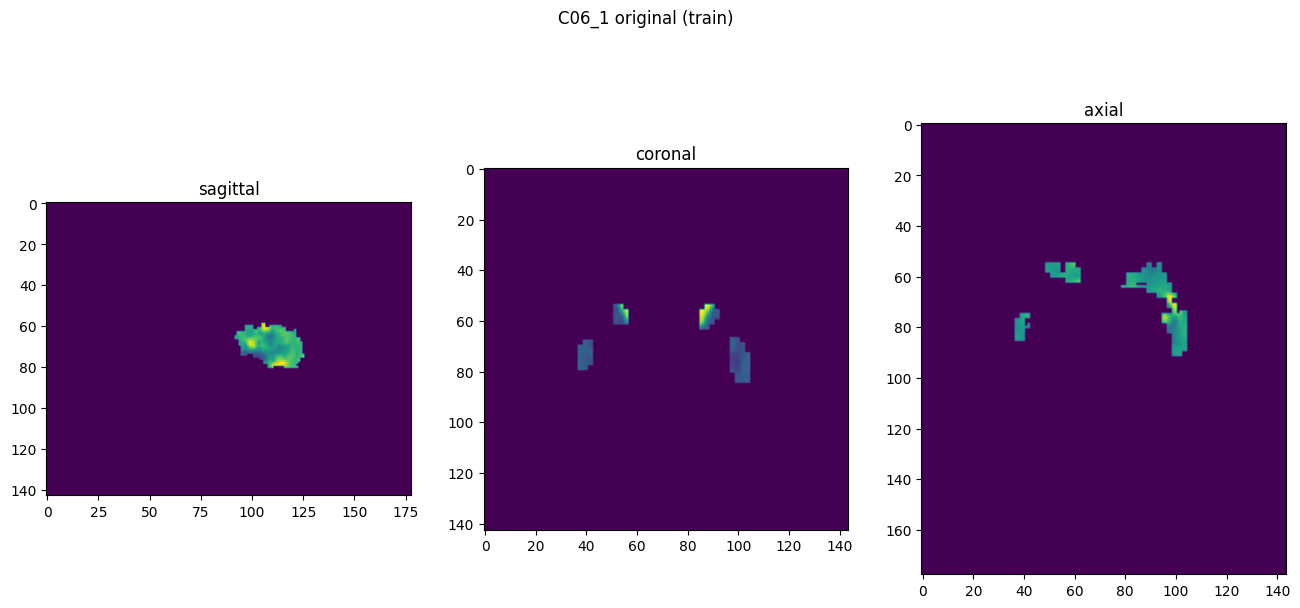

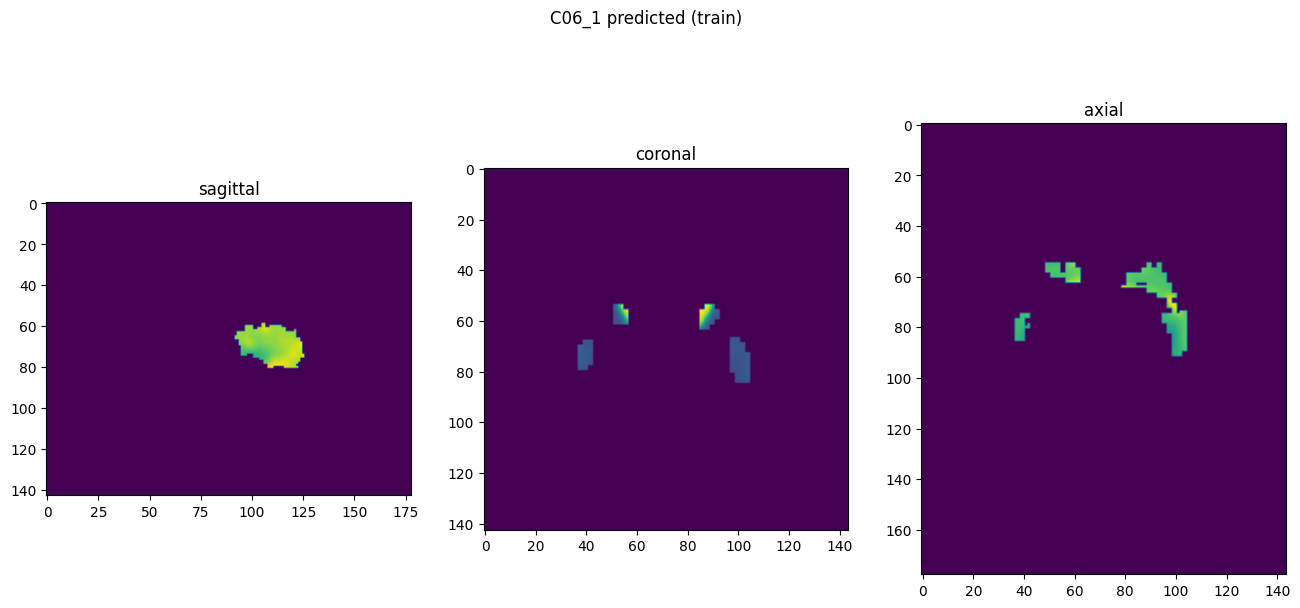

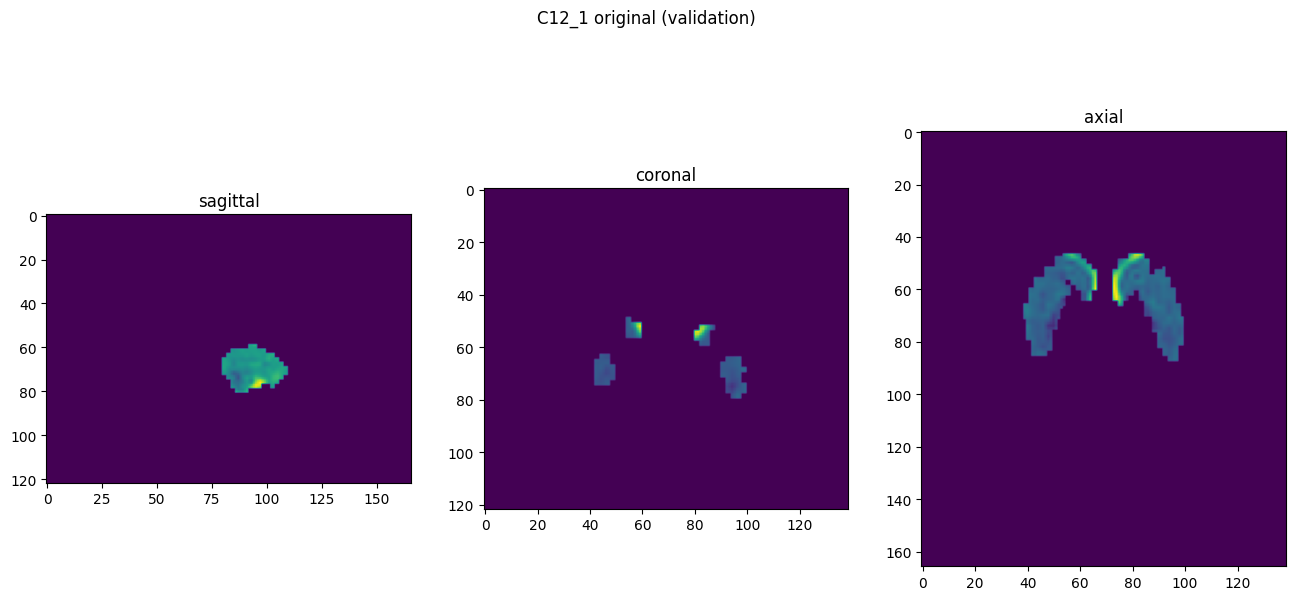

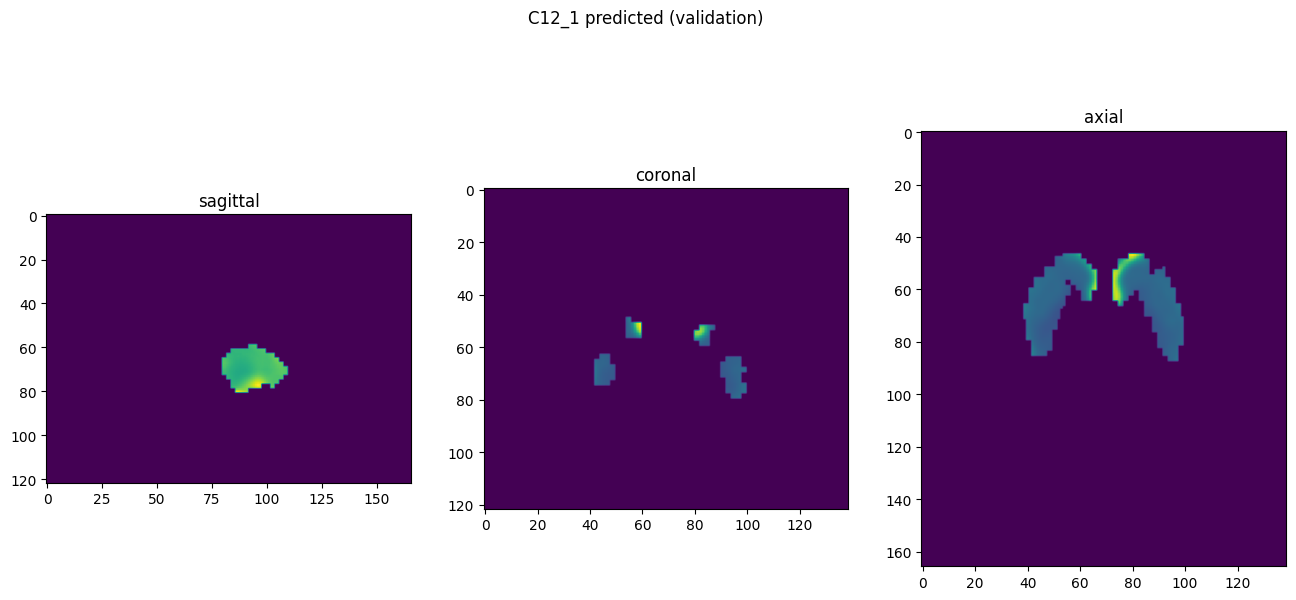

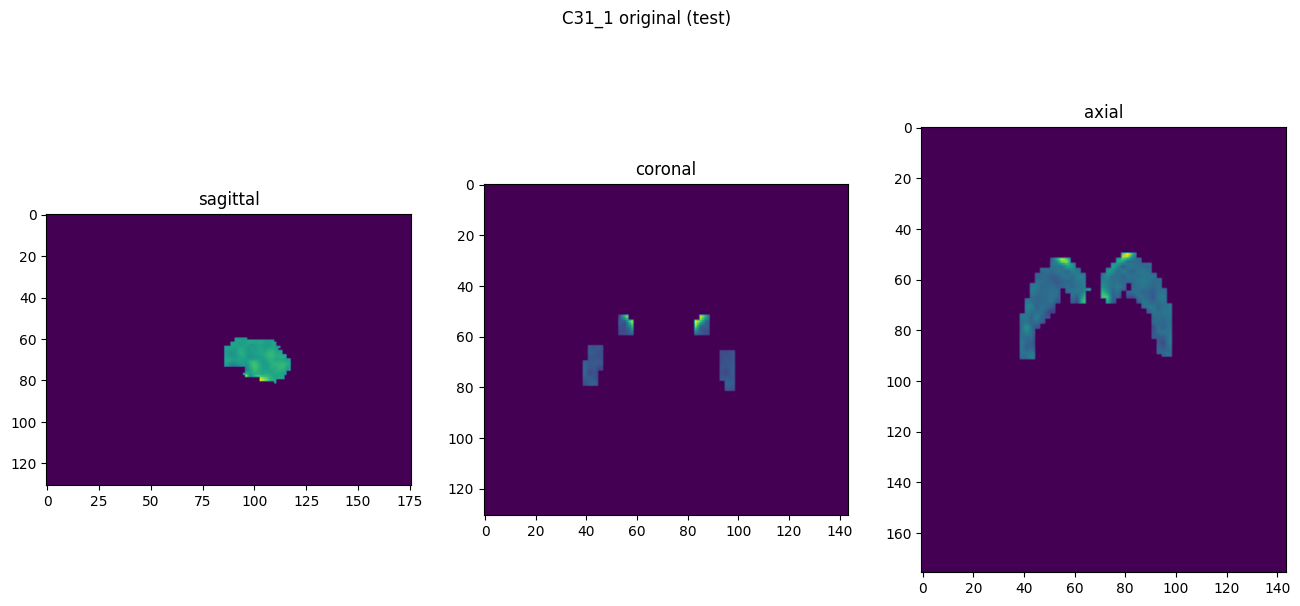

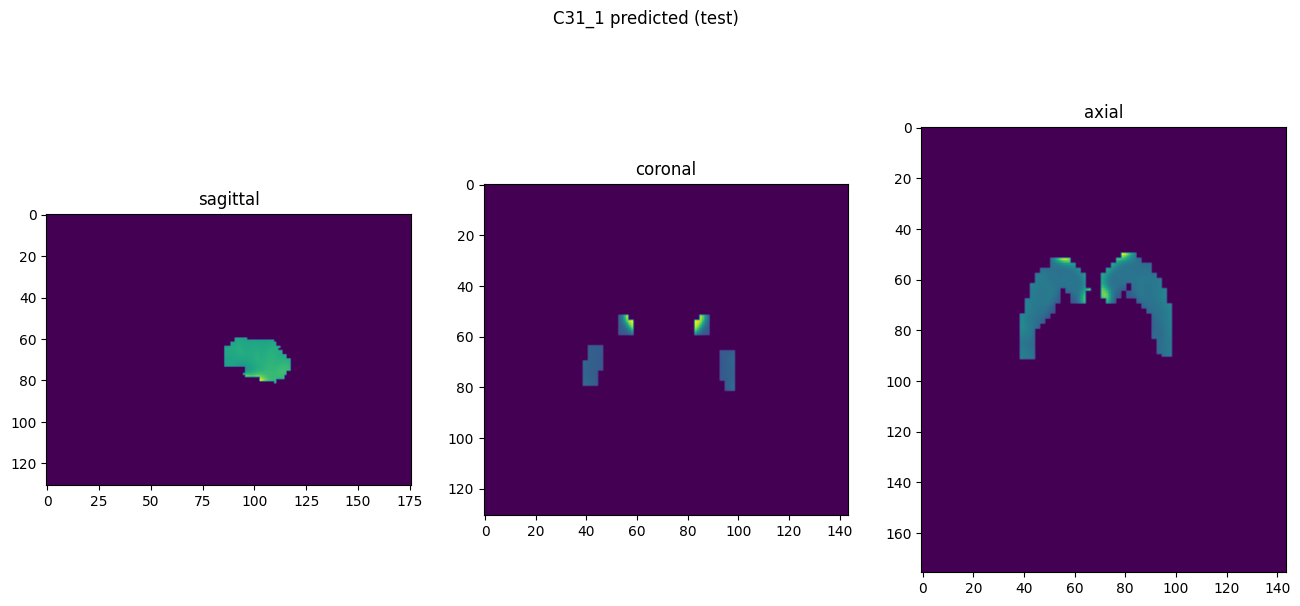

In [10]:
showResults(model, gen, threshold=None, background=False)